In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="1aurent/distilbert-base-multilingual-cased-finetuned-email-spam")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("farshad72/spam_email")
dataset = load_dataset("farshad72/spam_email")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

combined_data.csv:   0%|          | 0.00/140M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/83448 [00:00<?, ? examples/s]

In [ ]:
#inspect a sample
print(dataset['train'][0])

{'label': 1, 'text': 'ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage'}


In [ ]:
#check columns
print(dataset.column_names)

{'train': ['label', 'text']}


In [ ]:
#check for missing values
print(dataset['train'].filter(lambda x: x['text'] is None))

Filter:   0%|          | 0/83448 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text'],
    num_rows: 0
})


In [ ]:
#Remove extra spaces, special characters, and convert to lowercase.
def preprocess_text(example):
    example['text'] = example['text'].lower().strip()
    return example

dataset = dataset.map(preprocess_text)

Map:   0%|          | 0/83448 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("1aurent/distilbert-base-multilingual-cased-finetuned-email-spam")

def tokenize_data(example):
    return tokenizer(example['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/83448 [00:00<?, ? examples/s]

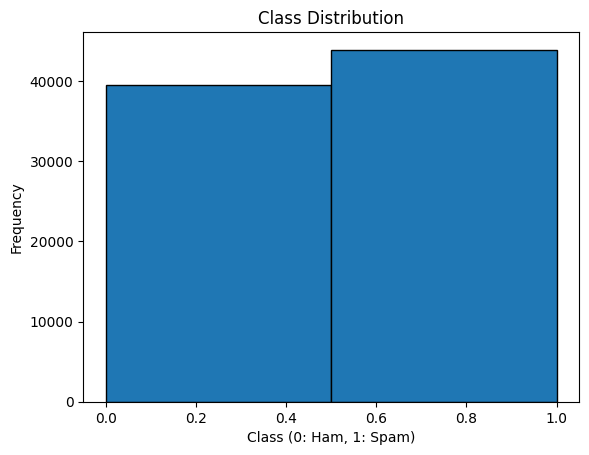

In [ ]:
import matplotlib.pyplot as plt

labels = [row['label'] for row in dataset['train']]
plt.hist(labels, bins=2, edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class (0: Ham, 1: Spam)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def word_frequency(dataset, label):
    all_words = []
    for row in dataset['train']:
        if row['label'] == label:
            all_words.extend([word for word in row['text'].split() if word not in stop_words])
    return Counter(all_words).most_common(20)

spam_words = word_frequency(dataset, 1)
ham_words = word_frequency(dataset, 0)

print("Spam Words:", spam_words)
print("Ham Words:", ham_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Spam Words: [('escapenumber', 333179), ('.', 196760), ('escapelong', 188102), (',', 126591), ('-', 80347), (':', 42349), ('_', 42324), ('/', 38523), ('com', 29001), ('http', 27754), ('per', 26141), ('x', 23817), ('!', 23572), ('pills', 23128), ('escapenumbermg', 20541), ("'", 19185), ('$', 18898), ('price', 18723), ('|', 18410), ('?', 18384)]
Ham Words: [('escapenumber', 798212), ('-', 292331), ('.', 255980), (',', 207749), ('/', 120002), (':', 104150), ("'", 57370), ('http', 54360), ('r', 53209), ('enron', 52856), ('c', 44279), ('org', 42530), ('com', 40658), ('@', 39034), ('escapelong', 38909), ('>', 34844), ('ect', 34743), (')', 32526), ('help', 32512), ('samba', 30703)]


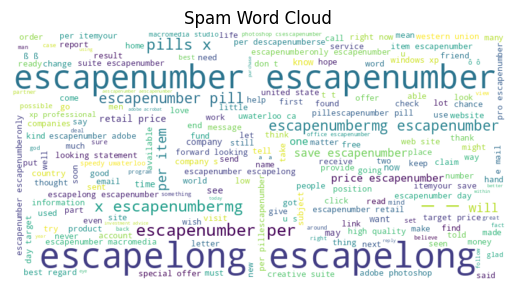

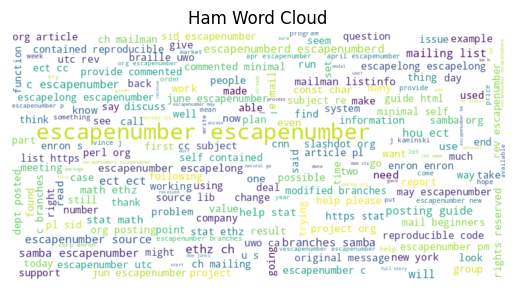

In [ ]:
from wordcloud import WordCloud

spam_text = " ".join([row['text'] for row in dataset['train'] if row['label'] == 1])
ham_text = " ".join([row['text'] for row in dataset['train'] if row['label'] == 0])

# Spam word cloud
spam_wc = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Spam Word Cloud')
plt.axis('off')
plt.show()

# Ham word cloud
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.imshow(ham_wc, interpolation='bilinear')
plt.title('Ham Word Cloud')
plt.axis('off')
plt.show()

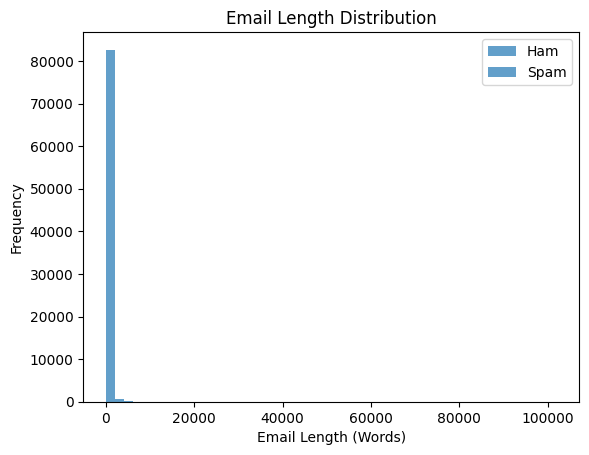

In [ ]:
email_lengths = [len(row['text'].split()) for row in dataset['train']]
labels = [row['label'] for row in dataset['train']]

plt.hist(email_lengths, bins=50, alpha=0.7, label=['Ham', 'Spam'])
plt.title('Email Length Distribution')
plt.xlabel('Email Length (Words)')
plt.ylabel('Frequency')
plt.legend(['Ham', 'Spam'])
plt.show()

In [ ]:
spam_classifier = pipeline("text-classification", model="1aurent/distilbert-base-multilingual-cased-finetuned-email-spam", tokenizer=tokenizer)

In [ ]:
sample_emails = [
    "Congratulations! You've won a $1000 gift card. Click here to claim.",
    "Here is the meeting agenda for tomorrow."
]

In [ ]:
predictions = spam_classifier(sample_emails)
for email, prediction in zip(sample_emails, predictions):
    print(f"Email: {email}\nPrediction: {prediction}\n")

Email: Congratulations! You've won a $1000 gift card. Click here to claim.
Prediction: {'label': 'spam', 'score': 0.8532842993736267}

Email: Here is the meeting agenda for tomorrow.
Prediction: {'label': 'spam', 'score': 0.6631397604942322}



In [ ]:
from datasets import load_dataset
dataset = load_dataset("farshad72/spam_email")
train_test = dataset['train'].train_test_split(test_size=0.2)

train_data = train_test['train']  # 80% for training
test_data = train_test['test']    # 20% for testing

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model
model_name = "1aurent/distilbert-base-multilingual-cased-finetuned-email-spam"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Tokenize input
text = "Congratulations! You've won a $1000 gift card."
tokenized_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move model and input to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
tokenized_input = {key: value.to(device) for key, value in tokenized_input.items()}

# Get model output
output = model(**tokenized_input)

# Extract predicted label
predicted_label = torch.argmax(output.logits, dim=1).item()
print("Ham" if predicted_label == 0 else "Spam")


Spam
